In [20]:
# モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

from sklearn.model_selection import KFold

import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


# data_road
train_data = pd.read_csv("../data/train.tsv", delimiter='\t')
test_data = pd.read_csv("../data/test.tsv", delimiter='\t')
x, y = train_data.iloc[:, 3:21], train_data["LeagueIndex"]-1
x_train, x_val, y_train, y_val = train_test_split(x, y)
x_test= test_data.iloc[:, 2:20]

In [ ]:
# カテゴリー変数
categorical_features = ['sepal_cat', 'petal_cat']


# 5-fold CVモデルの学習
# 5つのモデルを保存するリストの初期化
models = []

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=42)

# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y):
    # ilocで取り出す行を指定
    X_train_cv = x.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y).iloc[train_cv_no]
    X_eval_cv = x.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y).iloc[eval_cv_no]

    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv)

    # パラメータを設定
    params = {
              'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
              'metric': 'multi_logloss',      # 分類モデルの性能を測る指標
              'num_class': 8,                 # 目的変数のクラス数
             }

    # 学習
    evaluation_results = {}                                     # 学習の経過を保存する箱
    model = lgb.train(params,                                   # 上記で設定したパラメータ
                      lgb_train,
                      valid_names=['train', 'valid'],           # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                      evals_result=evaluation_results)

    # テストデータで予測する
    y_pred = model.predict(x_val, num_iteration=model.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)

    # Accuracy を計算する
    accuracy = sum(y_val == y_pred_max) / len(y_val)
    print('accuracy:', accuracy)

    # 学習が終わったモデルをリストに入れておく
    models.append(model)

In [ ]:
# 学習過程の可視化
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.savefig('cv_logloss.jpg')
plt.show()

In [18]:
params = {'loss_function': 'MultiClass'}
catb_model = cb.CatBoost(params)
k = 10
cv = KFold(n_splits=k, random_state=0, shuffle=True)
accuracy_list = []
for train_index, test_index in cv.split(x):
    print(train_index)
    # get train and test data
    train_x, test_x = x.iloc[train_index], x.iloc[test_index]
    train_y, test_y = y[train_index], y[test_index]
    # fit model
    catb_model.fit(x_train, y_train)
    # predict test data
    pred_y = catb_model.predict(test_x)
    pred_y_max = np.argmax(pred_y, axis=1)
    # loss
    score = accuracy_score(test_y, pred_y_max)
    accuracy_list.append(score)
    print('score:{0:.4f}'.format(score))

print(f"MSE({k}FoldCV): {np.mean(accuracy_list)}")
print(f"std: {np.std(accuracy_list)}")



[   0    1    2 ... 1694 1695 1696]
Learning rate set to 0.080104
0:	learn: 1.9995066	total: 14.9ms	remaining: 14.9s
1:	learn: 1.9463151	total: 21.2ms	remaining: 10.6s
2:	learn: 1.8947269	total: 25.9ms	remaining: 8.61s
3:	learn: 1.8526974	total: 30.4ms	remaining: 7.58s
4:	learn: 1.8082643	total: 34.9ms	remaining: 6.94s
5:	learn: 1.7704926	total: 39.5ms	remaining: 6.54s
6:	learn: 1.7351764	total: 43.8ms	remaining: 6.22s
7:	learn: 1.7007734	total: 48.2ms	remaining: 5.98s
8:	learn: 1.6727437	total: 53.1ms	remaining: 5.85s
9:	learn: 1.6383035	total: 57.5ms	remaining: 5.69s
10:	learn: 1.6087862	total: 62.4ms	remaining: 5.61s
11:	learn: 1.5798991	total: 66.9ms	remaining: 5.51s
12:	learn: 1.5553060	total: 71.4ms	remaining: 5.42s
13:	learn: 1.5316376	total: 77.5ms	remaining: 5.46s
14:	learn: 1.5112511	total: 82.3ms	remaining: 5.4s
15:	learn: 1.4887303	total: 86.9ms	remaining: 5.34s
16:	learn: 1.4713567	total: 91.7ms	remaining: 5.3s
17:	learn: 1.4504388	total: 96.5ms	remaining: 5.26s
18:	learn:

In [17]:
import csv

cat_pred = catb_model.predict(x_test)
cat_pred_sca = np.argmax(cat_pred, axis=1)
with open("../result/catboost_test.csv", "w") as csv_file:
    for pred_low, test_id in zip(cat_pred_sca, test_data['Unnamed: 0']):
        writer = csv.writer(csv_file)
        low = [test_id, int(pred_low + 1)]
        writer.writerow(low)

    csv_file.close()

In [ ]:
param = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
          'boosting_type': 'gbdt',        # 勾配ブースティング
          'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
          'metric': 'multi_logloss',      # 分類モデルの性能を測る指標
          'num_class': 8,                 # 目的変数のクラス数
         }

In [14]:
k = 5
cv = KFold(n_splits=k, random_state=0, shuffle=True)
accuracy_list = []
for train_index, test_index in cv.split(x):
    print(train_index)
    # get train and test data
    train_x, test_x = x.iloc[train_index], x.iloc[test_index]
    train_y, test_y = y[train_index], y[test_index]

    dtrain = lgb.Dataset(train_x, train_y, free_raw_data=False)
    dtest = lgb.Dataset(test_x)
    # fit model
    lgb_model = lgb.train(param,                                   # 上記で設定したパラメータ
                  dtrain)
    # predict test data
    pred_y = lgb_model.predict(test_x)
    pred_y_max = np.argmax(pred_y, axis=1)
    # loss
    score = accuracy_score(test_y, pred_y_max)
    accuracy_list.append(score)
    print('score:{0:.4f}'.format(score))

print(f"MSE({k}FoldCV): {np.mean(accuracy_list)}")
print(f"std: {np.std(accuracy_list)}")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [25]:
def xgb_train(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, X_test, y_test, loop_counts):
    # データを格納する
    # 学習用
    xgb_train = xgb.DMatrix(X_train_cv, label=y_train_cv)
    # 検証用
    xgb_eval = xgb.DMatrix(X_eval_cv, label=y_eval_cv)
    # テスト用
    xgb_test = xgb.DMatrix(X_test, label=y_test)

    # パラメータを設定
    xgb_params = {
        'objective': 'multi:softprob',  # 多値分類問題
        'num_class': 8,                 # 目的変数のクラス数
        'learning_rate': 0.1,           # 学習率
        'eval_metric': 'mlogloss'       # 学習用の指標 (Multiclass logloss)
    }

    # 学習
    evals = [(xgb_train, 'train'), (xgb_eval, 'eval')] # 学習に用いる検証用データ
    evaluation_results = {}                            # 学習の経過を保存する箱
    bst = xgb.train(xgb_params,                        # 上記で設定したパラメータ
                    xgb_train,                         # 使用するデータセット
                    num_boost_round=200,               # 学習の回数
                    early_stopping_rounds=10,          # アーリーストッピング
                    evals=evals,                       # 学習経過で表示する名称
                    evals_result=evaluation_results,   # 上記で設定した検証用データ
                    verbose_eval=0                     # 学習の経過の表示(非表示)
                    )

    # テストデータで予測
    y_pred = bst.predict(xgb_test, ntree_limit=bst.best_ntree_limit)
    y_pred_max = np.argmax(y_pred, axis=1)

    print('Trial: ' + str(loop_counts))
    accuracy = accuracy_score(y_test, y_pred_max)
    print('XGBoost Accuracy:', accuracy)

    return(bst, y_pred_max, accuracy)

def lgbm_train(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, X_test, y_test):
    # データを格納する
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            free_raw_data=False)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           free_raw_data=False)

    # パラメータを設定
    params = {'task': 'train',                # レーニング ⇔　予測predict
              'boosting_type': 'gbdt',        # 勾配ブースティング
              'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
              'metric': 'multi_logloss',      # 検証用データセットで、分類モデルの性能を測る指標
              'num_class': 8,                 # 目的変数のクラス数
              'learning_rate': 0.1,           # 学習率（初期値0.1）
              'num_leaves': 23,               # 決定木の複雑度を調整（初期値31）
              'min_data_in_leaf': 1,          # データの最小数（初期値20）
             }

    # 学習
    evaluation_results = {}                                # 学習の経過を保存する箱
    model = lgb.train(params,                              # 上記で設定したパラメータ
                      lgb_train,                           # 使用するデータセット
                      num_boost_round=200,                 # 学習の回数
                      valid_names=['train', 'valid'],      # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],    # モデルの検証に使用するデータセット
                      evals_result=evaluation_results,     # 学習の経過を保存
                      early_stopping_rounds=10,            # アーリーストッピングの回数
                      verbose_eval=0)                      # 学習の経過を表示する刻み（非表示）

    # テストデータで予測
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)

    # Accuracy の計算
    accuracy = sum(y_test == y_pred_max) / len(y_test)
    print('LightGBM Accuracy:', accuracy)

    return(model, y_pred_max, accuracy)

def catboost_train(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, X_test, y_test):
    # データを格納する
    # 学習用
    CatBoost_train = cb.Pool(X_train_cv, label=y_train_cv)
    # 検証用
    CatBoost_eval = cb.Pool(X_eval_cv, label=y_eval_cv)

    # パラメータを設定
    params = {
        'loss_function': 'MultiClass',    # 多値分類問題
        'num_boost_round': 200,          # 学習の回数
        'early_stopping_rounds': 10       # アーリーストッピングの回数
    }

    # 学習
    catb = cb.CatBoost(params)
    catb.fit(CatBoost_train, eval_set=[CatBoost_eval], verbose=False)

    # テストデータで予測
    y_pred = catb.predict(X_test, prediction_type='Probability')
    y_pred_max = np.argmax(y_pred, axis=1)

    # Accuracy の計算
    accuracy = sum(y_test == y_pred_max) / len(y_test)
    print('CatBoost Accuracy:', accuracy)

    return(catb, y_pred_max, accuracy)


In [26]:
# Voting
# 各5つのモデルを保存するリストの初期化
xgb_models = []
lgbm_models = []
catb_models = []
# 各5つのモデルの正答率を保存するリストの初期化
xgb_accuracies = []
lgbm_accuracies = []
catb_accuracies = []
# 学習のカウンター
loop_counts = 1


# 学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

# 各5つのモデルの予測を保存する配列の初期化（5seed*5cv*3モデル）
first_preds = np.zeros((len(y_test), 5*5*3))


# ５つのシード値で予測
for seed_no in range(5):

    # 学習データの数だけの数列（0行から最終行まで連番）
    row_no_list = list(range(len(y_train)))

    # KFoldクラスをインスタンス化（これを使って5分割する）
    K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state= seed_no)

    # KFoldクラスで分割した回数だけ実行（ここでは5回）
    for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
        # ilocで取り出す行を指定
        X_train_cv = X_train.iloc[train_cv_no, :]
        y_train_cv = pd.Series(y_train).iloc[train_cv_no]
        X_eval_cv = X_train.iloc[eval_cv_no, :]
        y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]

        # XGBoostの学習を実行
        bst, bst_pred, bst_accuracy = xgb_train(X_train_cv, y_train_cv,
                                                X_eval_cv, y_eval_cv,
                                                X_test, y_test,
                                                loop_counts)
        # LIghtGBMの学習を実行
        model, model_pred, model_accuracy = lgbm_train(X_train_cv, y_train_cv,
                                                       X_eval_cv, y_eval_cv,
                                                       X_test, y_test)
        # CatBoostの学習を実行
        catb, catb_pred, catb_accuracy = catboost_train(X_train_cv, y_train_cv,
                                                        X_eval_cv, y_eval_cv,
                                                        X_test, y_test)

        # 学習が終わったモデルをリストに入れておく
        xgb_models.append(bst)
        lgbm_models.append(model)
        catb_models.append(catb)

        # 学習が終わったモデルの正答率をリストに入れておく
        xgb_accuracies.append(bst_accuracy)
        lgbm_accuracies.append(model_accuracy)
        catb_accuracies.append(catb_accuracy)

        # 学習が終わったモデルの予測をリストに入れておく
        first_preds[:, loop_counts-1] = bst_pred
        first_preds[:, loop_counts-1 + 25] = model_pred
        first_preds[:, loop_counts-1 + 50] = catb_pred

        # 実行回数のカウント
        loop_counts += 1

/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 1
XGBoost Accuracy: 0.42058823529411765
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3735
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.40588235294117647
CatBoost Accuracy: 0.4323529411764706


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 2
XGBoost Accuracy: 0.4294117647058823
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3737
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.216747
[LightGBM] [Info] Start training from score -4.098964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.3911764705882353
CatBoost Accuracy: 0.43823529411764706


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 3
XGBoost Accuracy: 0.4088235294117647
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3730
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.808473
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.468796
[LightGBM] [Info] Start training from score -1.764510
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.36470588235294116
CatBoost Accuracy: 0.42058823529411765


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 4
XGBoost Accuracy: 0.3735294117647059
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3745
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.895912
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.37941176470588234
CatBoost Accuracy: 0.4411764705882353


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 5
XGBoost Accuracy: 0.40588235294117647
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3728
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.236666
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.414307
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.39705882352941174
CatBoost Accuracy: 0.4235294117647059


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 6
XGBoost Accuracy: 0.4323529411764706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.40294117647058825
CatBoost Accuracy: 0.43529411764705883


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 7
XGBoost Accuracy: 0.4323529411764706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3732
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.216747
[LightGBM] [Info] Start training from score -4.098964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.4323529411764706
CatBoost Accuracy: 0.43529411764705883


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 8
XGBoost Accuracy: 0.42058823529411765
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3729
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.808473
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.468796
[LightGBM] [Info] Start training from score -1.764510
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.40588235294117647
CatBoost Accuracy: 0.4411764705882353


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 9
XGBoost Accuracy: 0.40294117647058825
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3744
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.895912
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.40294117647058825
CatBoost Accuracy: 0.4294117647058823


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 10
XGBoost Accuracy: 0.38823529411764707
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3732
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.236666
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.414307
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.38823529411764707
CatBoost Accuracy: 0.3735294117647059


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 11
XGBoost Accuracy: 0.39705882352941174
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3737
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.37941176470588234
CatBoost Accuracy: 0.4235294117647059


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 12
XGBoost Accuracy: 0.40294117647058825
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3736
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.216747
[LightGBM] [Info] Start training from score -4.098964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.4323529411764706
CatBoost Accuracy: 0.4235294117647059


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 13
XGBoost Accuracy: 0.4088235294117647
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3734
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.808473
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.468796
[LightGBM] [Info] Start training from score -1.764510
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.38529411764705884
CatBoost Accuracy: 0.4470588235294118


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 14
XGBoost Accuracy: 0.42058823529411765
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3736
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.895912
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.40588235294117647
CatBoost Accuracy: 0.42058823529411765


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 15
XGBoost Accuracy: 0.3941176470588235
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3732
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.236666
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.414307
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.38529411764705884
CatBoost Accuracy: 0.4294117647058823


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 16
XGBoost Accuracy: 0.3941176470588235
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3741
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.39705882352941174
CatBoost Accuracy: 0.37058823529411766


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 17
XGBoost Accuracy: 0.42058823529411765
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3734
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.216747
[LightGBM] [Info] Start training from score -4.098964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.4264705882352941
CatBoost Accuracy: 0.45294117647058824


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 18
XGBoost Accuracy: 0.4147058823529412
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3727
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.808473
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.468796
[LightGBM] [Info] Start training from score -1.764510
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.37941176470588234
CatBoost Accuracy: 0.4088235294117647


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 19
XGBoost Accuracy: 0.38823529411764707
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3740
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.895912
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.40588235294117647
CatBoost Accuracy: 0.4147058823529412


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 20
XGBoost Accuracy: 0.40588235294117647
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3735
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.236666
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.414307
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.38529411764705884
CatBoost Accuracy: 0.4264705882352941


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 21
XGBoost Accuracy: 0.4235294117647059
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3735
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Info] Start training from score -4.156122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.4
CatBoost Accuracy: 0.4176470588235294


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 22
XGBoost Accuracy: 0.4088235294117647
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3730
[LightGBM] [Info] Number of data points in the train set: 1085, number of used features: 18
[LightGBM] [Info] Start training from score -2.911798
[LightGBM] [Info] Start training from score -2.244403
[LightGBM] [Info] Start training from score -1.807552
[LightGBM] [Info] Start training from score -1.417181
[LightGBM] [Info] Start training from score -1.467874
[LightGBM] [Info] Start training from score -1.763589
[LightGBM] [Info] Start training from score -4.216747
[LightGBM] [Info] Start training from score -4.098964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.3735294117647059
CatBoost Accuracy: 0.4411764705882353


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 23
XGBoost Accuracy: 0.4264705882352941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3731
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.808473
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.468796
[LightGBM] [Info] Start training from score -1.764510
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.38823529411764707
CatBoost Accuracy: 0.43823529411764706


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 24
XGBoost Accuracy: 0.38823529411764707
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.895912
[LightGBM] [Info] Start training from score -2.245324
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.418102
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.099885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.38235294117647056
CatBoost Accuracy: 0.43823529411764706


/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/sugarl/.conda/envs/data_final/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Trial: 25
XGBoost Accuracy: 0.39705882352941174
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3740
[LightGBM] [Info] Number of data points in the train set: 1086, number of used features: 18
[LightGBM] [Info] Start training from score -2.912719
[LightGBM] [Info] Start training from score -2.236666
[LightGBM] [Info] Start training from score -1.814107
[LightGBM] [Info] Start training from score -1.414307
[LightGBM] [Info] Start training from score -1.464804
[LightGBM] [Info] Start training from score -1.769901
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Info] Start training from score -4.157043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.38235294117647056
CatBoost Accuracy: 0.43823529411764706


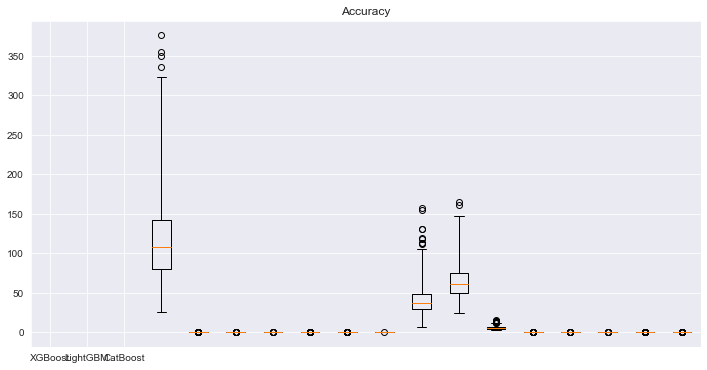

In [23]:
# 箱ひげ図の作成
plt.figure(figsize=(12, 6))
plt.boxplot(x, whis=3)
plt.xticks(range(1, 4), ['XGBoost', 'LightGBM', 'CatBoost'])
plt.title('Accuracy')
plt.show()

In [27]:
# 単独のモデルでの、テストデータの正答率
print('XGBoost Accuracy: ', np.array(xgb_accuracies).mean())
print('LightGBM Accuracy: ', np.array(lgbm_accuracies).mean())
print('CatBoost Accuracy: ', np.array(catb_accuracies).mean())
print('XGBoost std: ', np.array(xgb_accuracies).std())
print('LightGBM std: ', np.array(lgbm_accuracies).std())
print('CatBoost std: ', np.array(catb_accuracies).std())

XGBoost Accuracy:  0.40823529411764703
LightGBM Accuracy:  0.3951764705882353
CatBoost Accuracy:  0.42647058823529405
XGBoost std:  0.01542926711600471
LightGBM std:  0.01700559647347559
CatBoost std:  0.019061002054140762


In [28]:
# 単独のモデルでの、テストデータの正答率
print('XGBoost Accuracy: ', np.array(xgb_accuracies).max())
print('LightGBM Accuracy: ', np.array(lgbm_accuracies).max())
print('CatBoost Accuracy: ', np.array(catb_accuracies).max())

XGBoost Accuracy:  0.4323529411764706
LightGBM Accuracy:  0.4323529411764706
CatBoost Accuracy:  0.45294117647058824


In [29]:
np.array(catb_accuracies)

array([0.43235294, 0.43823529, 0.42058824, 0.44117647, 0.42352941,
       0.43529412, 0.43529412, 0.44117647, 0.42941176, 0.37352941,
       0.42352941, 0.42352941, 0.44705882, 0.42058824, 0.42941176,
       0.37058824, 0.45294118, 0.40882353, 0.41470588, 0.42647059,
       0.41764706, 0.44117647, 0.43823529, 0.43823529, 0.43823529])

In [33]:
import csv

y_pred = catb_models[16].predict(x_test)
y_pred_max = np.argmax(y_pred, axis=1)
with open("../result/catboost_test.csv", "w") as csv_file:
    for pred_low, test_id in zip(y_pred_max, test_data['Unnamed: 0']):
        writer = csv.writer(csv_file)
        low = [test_id, int(pred_low+1)]
        writer.writerow(low)

    csv_file.close()